# Supervised Contrastive Learning for OCT Encoder Pretraining
## Production Version with Robust Checkpointing

### Key Features:
- **Checkpoint resumption**: Resume training from any interruption
- **Periodic checkpoints**: Save every N epochs
- **Best model tracking**: Separate best model checkpoint
- **Training state preservation**: Save optimizer, scheduler, and random states
- **Progress logging**: Detailed CSV logs for analysis

### 目标
使用 biomarker 标签作为监督信号，训练 OCT encoder 学习临床语义特征。

### 数据
- 40 eyes × (首访 W0 + 末访) × 49 B-scans = 3,920 张有 biomarker 标签的 OCT 图像 (只取biomarker文件中有的对应的数据)
- 16 种 biomarker（二值标签）
- 使用预处理好的 `2_biomarker_processed.csv`

### 输出
- 预训练的 ResNet-18 encoder (`oct_encoder_supcon.pth`)
- 可应用于所有 visits 提取 OCT embeddings

---
## 1. Environment Setup and Configuration

In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.model_selection import train_test_split


print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch version: 2.2.2
CUDA available: True
CUDA version: 12.1
GPU: NVIDIA GeForce RTX 2070 SUPER
GPU Memory: 8.59 GB


In [2]:

SEED = 42


DATA_ROOT = "C:\\Users\\ronny\\Desktop\\Thesis\\Prime Images"
BIOMARKER_CSV = './2_biomarker_processed.csv'


OUTPUT_DIR = './supcon_output'
CHECKPOINT_DIR = os.path.join(OUTPUT_DIR, 'checkpoints')
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# ============================================================
# Training parameters
# ============================================================
BATCH_SIZE = 32          # Adjust based on GPU memory (RTX 2070 SUPER: 32-64 should work)
NUM_EPOCHS = 100         
LEARNING_RATE = 0.001    # Initial learning rate
WEIGHT_DECAY = 1e-4      # L2 regularization
TEMPERATURE = 0.07       # SupCon loss temperature
EMBEDDING_DIM = 256      # Encoder output dimension
IMAGE_SIZE = 224         # Input image size


CHECKPOINT_EVERY = 5     # Save checkpoint every N epochs
KEEP_LAST_N_CHECKPOINTS = 5  # Keep only last N checkpoints to save disk space
RESUME_TRAINING = True   # Set to True to resume from latest checkpoint

# Test mode (set to False for full training)
TEST_MODE = True
TEST_SAMPLES = 100       # Number of samples in test mode

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'\nUsing device: {device}')

# Print configuration summary
print(f"\n{'='*60}")
print("TRAINING CONFIGURATION")
print(f"{'='*60}")
print(f"Test Mode: {TEST_MODE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Checkpoint Every: {CHECKPOINT_EVERY} epochs")
print(f"Resume Training: {RESUME_TRAINING}")
print(f"{'='*60}")


Using device: cuda

TRAINING CONFIGURATION
Test Mode: True
Batch Size: 32
Epochs: 100
Learning Rate: 0.001
Checkpoint Every: 5 epochs
Resume Training: True


In [3]:
# ============================================================
# Reproducibility Setup 为了 checkpoint 恢复时保证完全可复现
# ============================================================

def set_seed(seed):
    """Set all random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_random_states():
    """Get current random states for checkpointing."""
    return {
        'python': random.getstate(),
        'numpy': np.random.get_state(),
        'torch': torch.get_rng_state(),
        'cuda': torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None
    }

def set_random_states(states):
    """Restore random states from checkpoint."""
    random.setstate(states['python'])
    np.random.set_state(states['numpy'])
    torch.set_rng_state(states['torch'])
    if states['cuda'] is not None and torch.cuda.is_available():
        torch.cuda.set_rng_state_all(states['cuda'])

# Set initial seed
set_seed(SEED)
print(f"Random seed set to: {SEED}")

Random seed set to: 42


---
## 2. Data Loading and Preprocessing

In [4]:
biomarker_df = pd.read_csv(BIOMARKER_CSV)
print(f"Loaded {len(biomarker_df)} B-scan records")
print(f"Columns: {list(biomarker_df.columns)}")

Loaded 3920 B-scan records
Columns: ['Path (Trial/Arm/Folder/Visit/Eye/Image Name)', 'Scan (n/49)', 'Atrophy / thinning of retinal layers', 'Disruption of EZ', 'DRIL', 'IR hemorrhages', 'IR HRF', 'Partially attached vitreous face', 'Fully attached vitreous face', 'Preretinal tissue/hemorrhage', 'Vitreous debris', 'VMT', 'DRT/ME', 'Fluid (IRF)', 'Fluid (SRF)', 'Disruption of RPE', 'PED (serous)', 'SHRM', 'Eye_ID', 'BCVA', 'CST', 'Patient_ID', 'Patient_ID_String', 'Week', 'Eye', 'OCT_Filename', 'B_scan_number']


In [5]:
biomarker_df['Patient'] = biomarker_df['Patient_ID_String']

# check first and last visit weeks per Patient-Eye
visit_summary = biomarker_df.groupby(['Patient', 'Eye']).agg({
    'Week': ['min', 'max', 'count']
}).reset_index()
visit_summary.columns = ['Patient', 'Eye', 'First_Week', 'Last_Week', 'Num_Bscans']

print(f'Total {len(visit_summary)} Patient-Eye combinations')
print('Check distribution of first and last visit weeks:')
print(f"First Week dist: {visit_summary['First_Week'].unique()}")
print(f"\nLast Week dist:")
print(visit_summary['Last_Week'].value_counts().sort_index())
visit_summary

Total 40 Patient-Eye combinations
Check distribution of first and last visit weeks:
First Week dist: [0.]

Last Week dist:
Last_Week
12.0      1
24.0      1
28.0      1
36.0      3
48.0      1
52.0      4
84.0      1
92.0      2
100.0     3
104.0    23
Name: count, dtype: int64


,Patient,Eye,First_Week,Last_Week,Num_Bscans
0,01-001,OS,0.0,104.0,98
1,01-002,OD,0.0,52.0,98
2,01-012,OD,0.0,104.0,98
3,01-013,OD,0.0,104.0,98
4,01-014,OS,0.0,104.0,98
5,01-020,OS,0.0,104.0,98
6,01-023,OD,0.0,92.0,98
7,01-025,OD,0.0,104.0,98
8,01-026,OD,0.0,104.0,98
9,01-027,OS,0.0,104.0,98


=== Biomarker Positive Rate Analysis ===



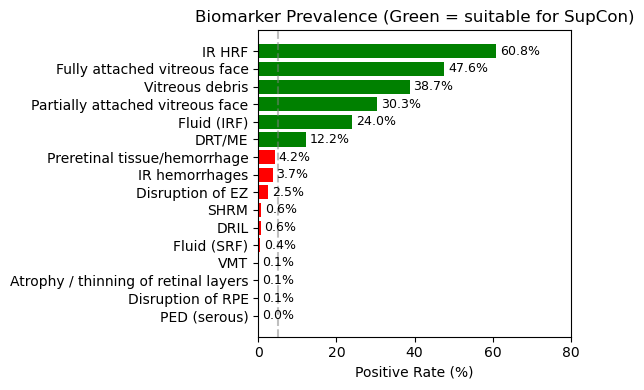

In [6]:
### 1) filter biomarkers with positive rate between 5% and 95%
ALL_BIOMARKER_COLS = [
    'Atrophy / thinning of retinal layers', 'Disruption of EZ', 'DRIL',
    'IR hemorrhages', 'IR HRF', 'Partially attached vitreous face',
    'Fully attached vitreous face', 'Preretinal tissue/hemorrhage',
    'Vitreous debris', 'VMT', 'DRT/ME', 'Fluid (IRF)', 'Fluid (SRF)',
    'Disruption of RPE', 'PED (serous)', 'SHRM'
]

# Calculate the positive rate for each biomarker
print('=== Biomarker Positive Rate Analysis ===')
print()
prevalence = {}
for col in ALL_BIOMARKER_COLS:
    pos_rate = biomarker_df[col].mean() * 100
    prevalence[col] = pos_rate


prevalence_sorted = dict(sorted(prevalence.items(), key=lambda x: x[1], reverse=True))


# Plot
plt.figure(figsize=(6, 4))
colors = ['green' if 5 <= v <= 95 else 'red' for v in prevalence_sorted.values()]
bars = plt.barh(list(prevalence_sorted.keys()), list(prevalence_sorted.values()), color=colors)


for bar, value in zip(bars, prevalence_sorted.values()):
    plt.text(
        bar.get_width() + 1,      # x position: slightly right of bar end
        bar.get_y() + bar.get_height()/2,  # y position: center of bar
        f'{value:.1f}%',          # text
        va='center',              # vertical alignment
        ha='left',                # horizontal alignment
        fontsize=9
    )

plt.axvline(x=5, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=95, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Positive Rate (%)')
plt.title('Biomarker Prevalence (Green = suitable for SupCon)')
plt.xlim(0, 80)  # Adjust x-axis to make room for annotations
plt.gca().invert_yaxis()  # Highest value at top
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/biomarker_prevalence.png', dpi=150)
plt.show()

In [7]:
# Selected biomarkers for SupCon (prevalence 5-95%)
SELECTED_BIOMARKERS = [
    'IR HRF',                        
    'Fully attached vitreous face',  
    'Vitreous debris',               
    'Partially attached vitreous face',
    'Fluid (IRF)',                   
    'DRT/ME',                       
]

print(f'Selected {len(SELECTED_BIOMARKERS)} biomarkers for SupCon training')

Selected 6 biomarkers for SupCon training


In [8]:
# 2） Create combined biomarker labels
def create_biomarker_label(row, biomarker_cols):
    """Create a string label representing the combination of selected biomarkers."""
    return '_'.join([str(int(row[col])) for col in biomarker_cols])

biomarker_df['label_str'] = biomarker_df.apply(
    lambda row: create_biomarker_label(row, SELECTED_BIOMARKERS), axis=1
)

# Create label mappings(Pytorch Dataloader needs numeric labels)
# i.e. convert '1_0_0_1_0_1' --> 0, '0_1_0_0_1_0' --> 1, etc.(A category -> A number). So 6-dim biomarkers -> 1 categorical
label_counts = biomarker_df['label_str'].value_counts()
label_to_idx = {label: idx for idx, label in enumerate(label_counts.index)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

biomarker_df['label_idx'] = biomarker_df['label_str'].map(label_to_idx)

print(f'Created {len(label_to_idx)} unique biomarker combination labels')
print(f'\nTop 10 most common combinations:')
print(label_counts.head(10))

Created 48 unique biomarker combination labels

Top 10 most common combinations:
label_str
0_1_0_0_0_0    405
1_1_1_0_0_0    386
1_1_0_0_0_0    377
0_1_1_0_0_0    309
1_0_0_1_0_0    307
0_0_0_1_0_0    227
0_0_0_0_0_0    188
1_0_0_0_0_0    183
1_0_1_1_0_0    146
1_0_1_0_0_0    138
Name: count, dtype: int64


In [9]:
# Patient-level train/val split
patients = biomarker_df['Patient_ID_String'].unique()
train_patients, val_patients = train_test_split(
    patients, test_size=0.2, random_state=SEED
)

train_df = biomarker_df[biomarker_df['Patient_ID_String'].isin(train_patients)].copy()
val_df = biomarker_df[biomarker_df['Patient_ID_String'].isin(val_patients)].copy()

# Apply test mode sampling if enabled
if TEST_MODE:
    train_df = train_df.sample(n=min(TEST_SAMPLES, len(train_df)), random_state=SEED)
    val_df = val_df.sample(n=min(TEST_SAMPLES // 5, len(val_df)), random_state=SEED)
    print(f"TEST MODE: Using {len(train_df)} train and {len(val_df)} val samples")

print(f'\nTrain: {len(train_df)} samples from {len(train_patients)} patients')
print(f'Val: {len(val_df)} samples from {len(val_patients)} patients')

TEST MODE: Using 100 train and 20 val samples

Train: 100 samples from 32 patients
Val: 20 samples from 8 patients


---
## 3. Dataset and DataLoader

In [10]:
# Data augmentations
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # 轻微缩放裁剪
    transforms.RandomHorizontalFlip(p=0.5), # OCT 可以水平翻转
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)), # 小角度旋转
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet 标准化
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
class OCTSupConDataset(Dataset):
    """
    Dataset for Supervised Contrastive Learning on OCT images.
    Returns two augmented views of the same image.
    使用预处理好的 2_biomarker_processed.csv 中的路径信息。
    
    对于 SupCon，每个样本返回:
    - 两个不同增强的图像视图 (view1, view2), view1：模型从这个角度看这张 OCT, view2：模型从另一个角度看这张 OCT; 同一图像的 view1 和 view2, 一定是 positive pair; 不同图像但 label 相同, 也是 positive; label 不同, 则为 negative pair
    - biomarker 组合标签
    """
    
    def __init__(self, df, data_root, transform=None):
        """
        Args:
            df: DataFrame，包含 Patient_ID_String, Week, Eye, B_scan_number, label_idx 列
            data_root: OCT 图像根目录 (Prime_FULL 的路径)
            transform: 图像变换
            return_two_views: 是否返回两个增强视图 (SupCon 训练时为 True)
        """
        self.df = df.reset_index(drop=True)
        self.data_root = data_root
        self.transform = transform
        self.path_col = 'Path (Trial/Arm/Folder/Visit/Eye/Image Name)'
        
    def __len__(self):
        return len(self.df)

    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # 直接使用 CSV 中的路径
        relative_path = row[self.path_col].lstrip('/')
        img_path = os.path.join(self.data_root, relative_path)
        
        # 处理扩展名：如果 .tif 不存在，尝试 .png
        if not os.path.exists(img_path):
            img_path = img_path.replace('.tif', '.png')
        
        image = Image.open(img_path).convert('RGB')
        label = row['label_idx']
        
        if self.transform:
            view1 = self.transform(image)
            view2 = self.transform(image)
            return view1, view2, label
        
        return image, image, label

class OCTValDataset(Dataset):
    """Validation dataset - returns single view without augmentation."""
    
    def __init__(self, df, data_root, transform=None):
        self.df = df.reset_index(drop=True)
        self.data_root = data_root
        self.transform = transform
        self.path_col = 'Path (Trial/Arm/Folder/Visit/Eye/Image Name)'
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        relative_path = row[self.path_col].lstrip('/')
        img_path = os.path.join(self.data_root, relative_path)
        
        if not os.path.exists(img_path):
            img_path = img_path.replace('.tif', '.png')
        
        image = Image.open(img_path).convert('RGB')
        label = row['label_idx']

        if self.transform:
            image = self.transform(image)
        
        return image, label

In [12]:
# Create datasets and dataloaders
train_dataset = OCTSupConDataset(train_df, DATA_ROOT, transform=train_transform)
val_dataset = OCTValDataset(val_df, DATA_ROOT, transform=val_transform)

# Use more workers for faster data loading
num_workers = 4 if not TEST_MODE else 0

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=True  # Important for SupCon loss calculation
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f'Train loader: {len(train_loader)} batches')
print(f'Val loader: {len(val_loader)} batches')

Train loader: 3 batches
Val loader: 1 batches


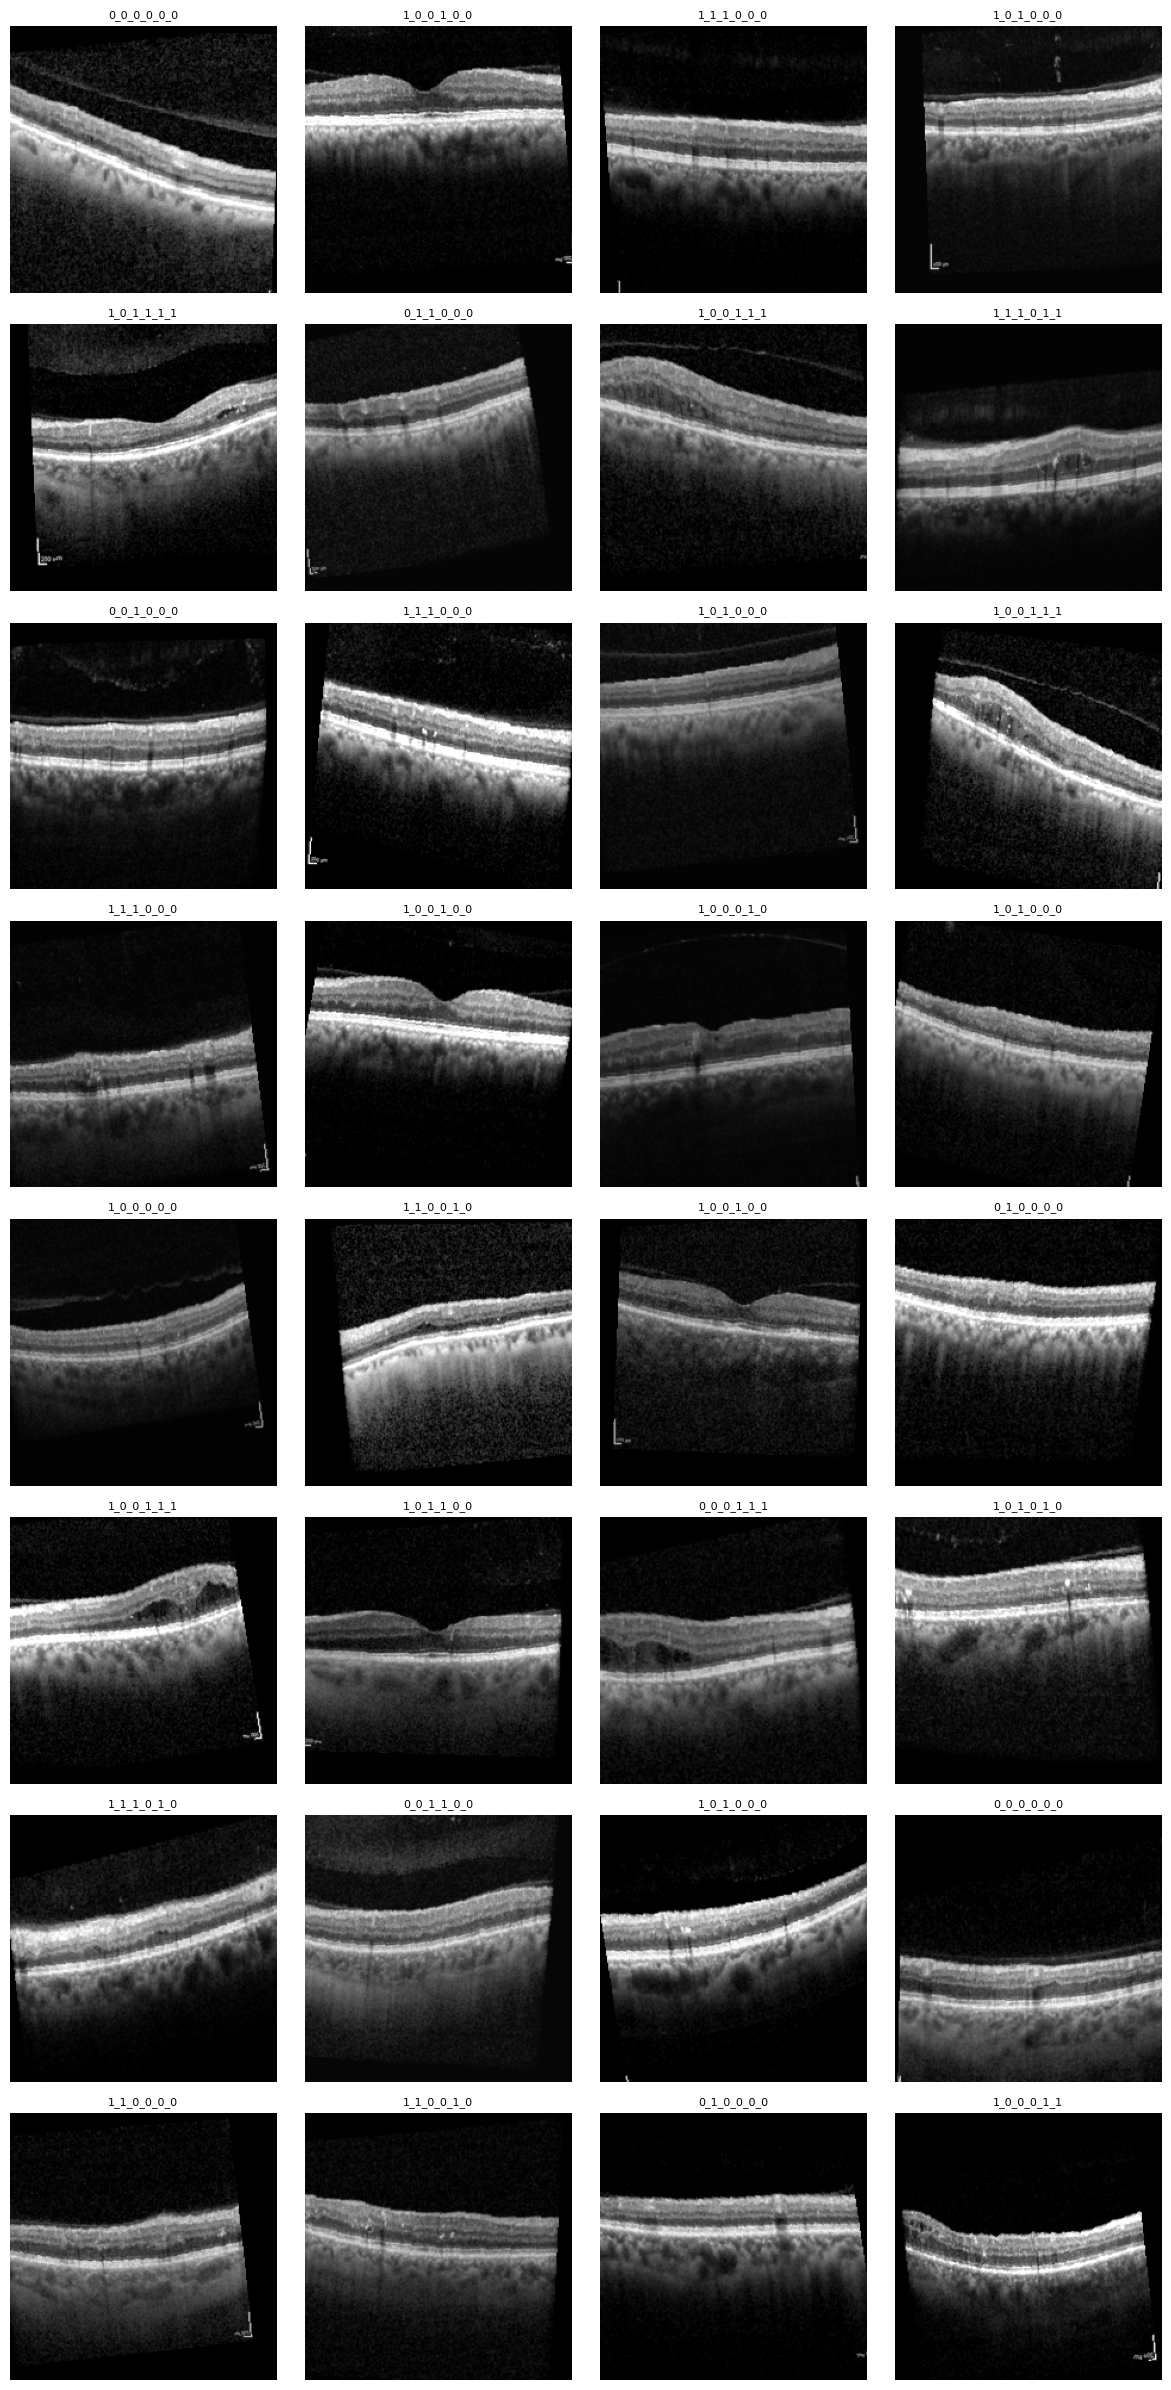

✓ 显示 32 张图像成功！


In [13]:
# 可视化一个 batch 的数据
def show_batch(dataloader, n_samples=None):
    """显示一个 batch 的图像"""
    try:
        batch = next(iter(dataloader))
        if len(batch) == 3:
            view1, view2, labels = batch
            images = view1
        else:
            images, labels = batch
        
        # 自动确定显示数量
        if n_samples is None:
            n_samples = len(images)
        else:
            n_samples = min(n_samples, len(images))
        
        # 动态计算行列数
        n_cols = min(4, n_samples)
        n_rows = (n_samples + n_cols - 1) // n_cols
        
        # 反标准化
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        images = images * std + mean
        images = torch.clamp(images, 0, 1)
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
        if n_samples == 1:
            axes = [axes]
        else:
            axes = axes.flat
            
        for i, ax in enumerate(axes):
            if i < n_samples:
                img = images[i].permute(1, 2, 0).numpy()
                ax.imshow(img)
                label_str = idx_to_label.get(labels[i].item(), 'unknown')
                ax.set_title(f'{label_str}', fontsize=8)
            ax.axis('off')
            
        plt.tight_layout()
        plt.savefig(f'{OUTPUT_DIR}/sample_batch.png', dpi=150)
        plt.show()
        print(f'✓ 显示 {n_samples} 张图像成功！')
    except Exception as e:
        print(f'无法显示图像: {e}')

show_batch(train_loader)

---
## 4. Model Architecture

用 ImageNet 预训练的 ResNet-18 作为 OCT encoder，学习一个 256 维、语义稳定的表示；再通过一个独立的 projection head，把表示映射到一个更适合 Supervised Contrastive Learning 的对比空间，在该空间中施加 SupCon loss，而最终下游任务只使用 encoder 的输出。

In [14]:
class OCTEncoder(nn.Module):
    """OCT Encoder based on ResNet-18.输出: 256 维 embedding 向量"""
    
    def __init__(self, embedding_dim=256, pretrained=True):
        super(OCTEncoder, self).__init__()
        # 加载预训练的 ResNet-18
        if pretrained:
            self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        else:
            self.backbone = models.resnet18(weights=None)
        
        # 获取特征维度
        in_features = self.backbone.fc.in_features  # 512 for ResNet-18
        
        # 替换最后的全连接层为 embedding 层
        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, embedding_dim)
        )
        
        self.embedding_dim = embedding_dim
        
    def forward(self, x):
        """
        Args:
            x: [B, 3, H, W] 输入图像
        Returns:
            embedding: [B, embedding_dim] 归一化的 embedding
        """
        embedding = self.backbone(x)
        embedding = F.normalize(embedding, p=2, dim=1) # L2 归一化 - 对于对比学习很重要
        return embedding


class ProjectionHead(nn.Module):
    """Projection head for contrastive learning.将 encoder 的输出投影到对比学习空间。"""
    
    def __init__(self, input_dim=256, hidden_dim=256, output_dim=128):
        super(ProjectionHead, self).__init__()
        
        self.projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        z = self.projection(x)
        z = F.normalize(z, p=2, dim=1)
        return z


class SupConModel(nn.Module):
    """Complete model for Supervised Contrastive Learning. 结构:Image → Encoder → Embedding → ProjectionHead → Contrastive Space"""
    
    def __init__(self, embedding_dim=256, projection_dim=128, pretrained=True):
        super(SupConModel, self).__init__()
        
        self.encoder = OCTEncoder(embedding_dim=embedding_dim, pretrained=pretrained)
        self.projection_head = ProjectionHead(
            input_dim=embedding_dim,
            hidden_dim=embedding_dim,
            output_dim=projection_dim
        )
        
    def forward(self, x):
        """
        Args:
            x: [B, 3, H, W]
        Returns:
            embedding: [B, embedding_dim] - 用于下游任务
            z: [B, projection_dim] - 用于对比学习
        """
        embedding = self.encoder(x)
        z = self.projection_head(embedding)
        return embedding, z
    
    def get_embedding(self, x):
        """Get embedding only (for downstream tasks)."""
        return self.encoder(x)

In [15]:
# Initialize model
model = SupConModel(
    embedding_dim=EMBEDDING_DIM,
    projection_dim=128,
    pretrained=True
).to(device)

print('The Model Info:\n', model)
print(f'Total parameters: {sum(p.numel() for p in model.parameters()):,}')
print(f'Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

The Model Info:
 SupConModel(
  (encoder): OCTEncoder(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

---
## 5. Supervised Contrastive Loss

In [16]:
class SupConLoss(nn.Module):
    """
    Supervised Contrastive Loss.
    
    参考: "Supervised Contrastive Learning" (Khosla et al., NeurIPS 2020)
    
    核心思想:
    - 相同标签的样本（正样本对）embedding 应该接近
    - 不同标签的样本（负样本对）embedding 应该远离
    """
    def __init__(self, temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        
    def forward(self, features, labels):
        """
        Args:
            features: [2*B, D] - 两个视图的特征拼接
            labels: [B] - 样本标签
            
        Returns:
            loss: scalar
        """
        device = features.device
        batch_size = labels.shape[0]
        
        # Duplicate labels for two views复制标签 (因为有两个视图)
        labels = labels.contiguous().view(-1, 1)
        labels = torch.cat([labels, labels], dim=0)
        
        # Cosine similarity matrix
        similarity_matrix = torch.matmul(features, features.T)
        
        # Label mask 创建标签掩码: mask[i,j] = 1 if labels[i] == labels[j]
        mask = torch.eq(labels, labels.T).float().to(device)
        
        # Exclude self-contrast排除自身对比 (对角线)
        logits_mask = torch.ones_like(mask) - torch.eye(2 * batch_size).to(device)
        mask = mask * logits_mask
        
        # Calculate logits
        logits = similarity_matrix / self.temperature
        
        # Numerical stability 数值稳定性: 减去每行最大值
        logits_max, _ = torch.max(logits, dim=1, keepdim=True)
        logits = logits - logits_max.detach()
        
        # 计算 log-softmax
        exp_logits = torch.exp(logits) * logits_mask# 排除自身
        log_prob = logits - torch.log(exp_logits.sum(dim=1, keepdim=True) + 1e-12)
        
        # Average log-prob of positive pairs 计算正样本对的平均 log-prob
        mask_sum = mask.sum(dim=1)
        mask_sum = torch.where(mask_sum > 0, mask_sum, torch.ones_like(mask_sum)) # 避免除以0：只考虑有正样本对的锚点
        
        mean_log_prob_pos = (mask * log_prob).sum(dim=1) / mask_sum

        # loss
        loss = -mean_log_prob_pos.mean()
        
        return loss

criterion = SupConLoss(temperature=TEMPERATURE)
print(f"SupConLoss initialized with temperature={TEMPERATURE}")

SupConLoss initialized with temperature=0.07


---
## 6. Checkpointing System

In [25]:
CHECKPOINT_DIR #Windows 实际上两种分隔符都接受：/ 正斜杠 ✅； \\ 反斜杠 ✅

'./supcon_output\\checkpoints'

In [17]:
class CheckpointManager:
    """
    Manages checkpoints for training resumption.
    
    Features:
    - Periodic checkpoints (every N epochs)
    - Best model tracking
    - Automatic cleanup of old checkpoints
    - Complete state restoration (model, optimizer, scheduler, random states)
    """
    
    def __init__(self, checkpoint_dir, keep_last_n=5):
        self.checkpoint_dir = checkpoint_dir
        self.keep_last_n = keep_last_n
        os.makedirs(checkpoint_dir, exist_ok=True)
        
    def save_checkpoint(self, state, epoch, is_best=False, filename=None):
        """
        Save a checkpoint.
        
        Args:
            state: Dictionary containing training state
            epoch: Current epoch number
            is_best: Whether this is the best model so far
            filename: Custom filename (optional)
        """
        if filename is None:
            filename = f'checkpoint_epoch_{epoch:04d}.pth'
        
        filepath = os.path.join(self.checkpoint_dir, filename)
        
        # Add metadata
        state['checkpoint_time'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        state['epoch'] = epoch
        
        torch.save(state, filepath)
        print(f"  ✓ Checkpoint saved: {filename}")
        
        # Save best model separately
        if is_best:
            best_path = os.path.join(self.checkpoint_dir, 'best_model.pth')
            torch.save(state, best_path)
            print(f"  ✓ Best model updated!")
        
        # Cleanup old checkpoints
        self._cleanup_old_checkpoints()
        
    def _cleanup_old_checkpoints(self):
        """Remove old checkpoints, keeping only the last N."""
        checkpoints = sorted([
            f for f in os.listdir(self.checkpoint_dir)
            if f.startswith('checkpoint_epoch_') and f.endswith('.pth')
        ])
        
        if len(checkpoints) > self.keep_last_n:
            for ckpt in checkpoints[:-self.keep_last_n]:
                os.remove(os.path.join(self.checkpoint_dir, ckpt))
                print(f"  Removed old checkpoint: {ckpt}")
    
    def load_latest_checkpoint(self):
        """Load the most recent checkpoint."""
        checkpoints = sorted([
            f for f in os.listdir(self.checkpoint_dir)
            if f.startswith('checkpoint_epoch_') and f.endswith('.pth')
        ])
        
        if not checkpoints:
            print("No checkpoints found. Starting from scratch.")
            return None
        
        latest = checkpoints[-1]
        filepath = os.path.join(self.checkpoint_dir, latest)
        print(f"Loading checkpoint: {latest}")
        
        return torch.load(filepath, map_location=device)
    
    def load_best_checkpoint(self):
        """Load the best model checkpoint."""
        best_path = os.path.join(self.checkpoint_dir, 'best_model.pth')
        
        if not os.path.exists(best_path):
            print("No best model checkpoint found.")
            return None
        
        print("Loading best model checkpoint...")
        return torch.load(best_path, map_location=device)


# Initialize checkpoint manager
checkpoint_manager = CheckpointManager(
    CHECKPOINT_DIR, 
    keep_last_n=KEEP_LAST_N_CHECKPOINTS
)
print(f"Checkpoint manager initialized. Checkpoints will be saved to: {CHECKPOINT_DIR}")

Checkpoint manager initialized. Checkpoints will be saved to: ./supcon_output\checkpoints


In [18]:
class TrainingLogger:
    """
    Logs training progress to CSV for monitoring and analysis.
    """
    
    def __init__(self, output_dir):
        self.log_path = os.path.join(output_dir, 'training_log.csv')
        self.logs = []
        
        # Load existing logs if resuming
        if os.path.exists(self.log_path):
            self.logs = pd.read_csv(self.log_path).to_dict('records')
            print(f"Loaded existing training log with {len(self.logs)} entries")
    
    def log(self, epoch, train_loss, val_loss=None, lr=None, best_loss=None):
        """Log training metrics."""
        entry = {
            'epoch': epoch,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'learning_rate': lr,
            'best_loss': best_loss,
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        self.logs.append(entry)
        
        # Save to CSV
        pd.DataFrame(self.logs).to_csv(self.log_path, index=False)
    
    def get_history(self):
        """Get training history as DataFrame."""
        return pd.DataFrame(self.logs)


# Initialize logger
training_logger = TrainingLogger(OUTPUT_DIR)
print(f"Training logger initialized. Logs will be saved to: {OUTPUT_DIR}/training_log.csv")

Training logger initialized. Logs will be saved to: ./supcon_output/training_log.csv


---
## 7. Training Functions

In [19]:
def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    num_batches = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
    for view1, view2, labels in pbar:
        view1 = view1.to(device)
        view2 = view2.to(device)
        labels = labels.to(device)
        
        # Combine views
        images = torch.cat([view1, view2], dim=0)
        
        # Forward
        _, z = model(images)
        
        # Loss
        loss = criterion(z, labels)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / num_batches


def validate(model, val_loader, criterion, device):
    """Validate the model."""
    model.eval()
    total_loss = 0
    num_batches = 0
    
    all_embeddings = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation'):
            images = images.to(device)
            labels = labels.to(device)
            
            # Get embeddings
            embedding = model.get_embedding(images)
            
            all_embeddings.append(embedding.cpu())
            all_labels.append(labels.cpu())
    
    all_embeddings = torch.cat(all_embeddings, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    return all_embeddings, all_labels

---
## 8. Training Loop with Checkpointing

In [20]:
# Initialize optimizer and scheduler
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=LEARNING_RATE, 
    weight_decay=WEIGHT_DECAY
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=NUM_EPOCHS, 
    eta_min=1e-6
)

# Training state
start_epoch = 0
best_loss = float('inf')
train_losses = []

# Resume from checkpoint if available
if RESUME_TRAINING:
    checkpoint = checkpoint_manager.load_latest_checkpoint()
    if checkpoint is not None:
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_loss = checkpoint['best_loss']
        train_losses = checkpoint.get('train_losses', [])
        
        # Restore random states
        if 'random_states' in checkpoint:
            set_random_states(checkpoint['random_states'])
        
        print(f"\nResumed from epoch {start_epoch}")
        print(f"Best loss so far: {best_loss:.4f}")
        print(f"Previous training losses: {len(train_losses)} epochs")

print(f"\nStarting training from epoch {start_epoch + 1}")

No checkpoints found. Starting from scratch.

Starting training from epoch 1


In [21]:
# ============================================================
# Main Training Loop
# ============================================================

print('='*70)
print('SUPERVISED CONTRASTIVE LEARNING TRAINING')
print('='*70)
print(f'Start Time: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
print(f'Total Epochs: {NUM_EPOCHS}')
print(f'Starting Epoch: {start_epoch + 1}')
print('='*70)

try:
    for epoch in range(start_epoch, NUM_EPOCHS):
        epoch_start_time = datetime.now()
        current_lr = scheduler.get_last_lr()[0]
        
        print(f'\n{"="*70}')
        print(f'Epoch {epoch + 1}/{NUM_EPOCHS} | LR: {current_lr:.6f}')
        print(f'{"="*70}')
        
        # Train
        train_loss = train_one_epoch(
            model, train_loader, criterion, optimizer, device, epoch + 1
        )
        train_losses.append(train_loss)
        
        # Update scheduler
        scheduler.step()
        
        # Check if best model
        is_best = train_loss < best_loss
        if is_best:
            best_loss = train_loss
        
        # Log progress
        epoch_time = (datetime.now() - epoch_start_time).total_seconds() / 60
        print(f'\nEpoch {epoch + 1} Summary:')
        print(f'  Train Loss: {train_loss:.4f}')
        print(f'  Best Loss: {best_loss:.4f}')
        print(f'  Time: {epoch_time:.2f} min')
        
        training_logger.log(
            epoch=epoch + 1,
            train_loss=train_loss,
            lr=current_lr,
            best_loss=best_loss
        )
        
        # Save checkpoint
        if (epoch + 1) % CHECKPOINT_EVERY == 0 or is_best or (epoch + 1) == NUM_EPOCHS:
            checkpoint_state = {
                'model_state_dict': model.state_dict(),
                'encoder_state_dict': model.encoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'epoch': epoch,
                'train_loss': train_loss,
                'best_loss': best_loss,
                'train_losses': train_losses,
                'random_states': get_random_states(),
                'config': {
                    'batch_size': BATCH_SIZE,
                    'learning_rate': LEARNING_RATE,
                    'temperature': TEMPERATURE,
                    'embedding_dim': EMBEDDING_DIM,
                    'num_epochs': NUM_EPOCHS,
                }
            }
            checkpoint_manager.save_checkpoint(checkpoint_state, epoch + 1, is_best)
        
        # Clear GPU cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

except KeyboardInterrupt:
    print('\n\n' + '='*70)
    print('TRAINING INTERRUPTED!')
    print('Saving emergency checkpoint...')
    print('='*70)
    
    emergency_state = {
        'model_state_dict': model.state_dict(),
        'encoder_state_dict': model.encoder.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'epoch': epoch,
        'train_loss': train_loss if 'train_loss' in dir() else None,
        'best_loss': best_loss,
        'train_losses': train_losses,
        'random_states': get_random_states(),
        'interrupted': True
    }
    checkpoint_manager.save_checkpoint(
        emergency_state, 
        epoch + 1, 
        filename='checkpoint_interrupted.pth'
    )
    print('Emergency checkpoint saved. You can resume training later.')

except Exception as e:
    print(f'\n\nERROR: {str(e)}')
    print('Saving error checkpoint...')
    
    error_state = {
        'model_state_dict': model.state_dict(),
        'encoder_state_dict': model.encoder.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'epoch': epoch if 'epoch' in dir() else 0,
        'best_loss': best_loss,
        'train_losses': train_losses,
        'error': str(e)
    }
    checkpoint_manager.save_checkpoint(
        error_state, 
        epoch + 1 if 'epoch' in dir() else 0, 
        filename='checkpoint_error.pth'
    )
    raise

print('\n' + '='*70)
print('TRAINING COMPLETE!')
print(f'End Time: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
print(f'Best Loss: {best_loss:.4f}')
print('='*70)

SUPERVISED CONTRASTIVE LEARNING TRAINING
Start Time: 2025-12-15 13:46:09
Total Epochs: 100
Starting Epoch: 1

Epoch 1/100 | LR: 0.001000


Epoch 1: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s, loss=4.0280]



Epoch 1 Summary:
  Train Loss: 4.0870
  Best Loss: 4.0870
  Time: 0.04 min
  ✓ Checkpoint saved: checkpoint_epoch_0001.pth
  ✓ Best model updated!

Epoch 2/100 | LR: 0.001000


Epoch 2: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s, loss=4.0232]



Epoch 2 Summary:
  Train Loss: 4.0226
  Best Loss: 4.0226
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0002.pth
  ✓ Best model updated!

Epoch 3/100 | LR: 0.000999


Epoch 3: 100%|██████████| 3/3 [00:00<00:00,  3.16it/s, loss=3.9708]



Epoch 3 Summary:
  Train Loss: 3.9465
  Best Loss: 3.9465
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0003.pth
  ✓ Best model updated!

Epoch 4/100 | LR: 0.000998


Epoch 4: 100%|██████████| 3/3 [00:00<00:00,  3.35it/s, loss=3.8842]



Epoch 4 Summary:
  Train Loss: 3.9614
  Best Loss: 3.9465
  Time: 0.01 min

Epoch 5/100 | LR: 0.000996


Epoch 5: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s, loss=3.5577]



Epoch 5 Summary:
  Train Loss: 3.7548
  Best Loss: 3.7548
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0005.pth
  ✓ Best model updated!

Epoch 6/100 | LR: 0.000994


Epoch 6: 100%|██████████| 3/3 [00:00<00:00,  3.39it/s, loss=3.9668]



Epoch 6 Summary:
  Train Loss: 3.7553
  Best Loss: 3.7548
  Time: 0.01 min

Epoch 7/100 | LR: 0.000991


Epoch 7: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s, loss=3.7568]



Epoch 7 Summary:
  Train Loss: 3.8804
  Best Loss: 3.7548
  Time: 0.02 min

Epoch 8/100 | LR: 0.000988


Epoch 8: 100%|██████████| 3/3 [00:00<00:00,  3.34it/s, loss=3.8269]



Epoch 8 Summary:
  Train Loss: 3.7518
  Best Loss: 3.7518
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0008.pth
  ✓ Best model updated!

Epoch 9/100 | LR: 0.000984


Epoch 9: 100%|██████████| 3/3 [00:00<00:00,  3.33it/s, loss=3.5897]



Epoch 9 Summary:
  Train Loss: 3.6477
  Best Loss: 3.6477
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0009.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0001.pth

Epoch 10/100 | LR: 0.000980


Epoch 10: 100%|██████████| 3/3 [00:00<00:00,  3.17it/s, loss=3.5978]



Epoch 10 Summary:
  Train Loss: 3.6598
  Best Loss: 3.6477
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0010.pth
  Removed old checkpoint: checkpoint_epoch_0002.pth

Epoch 11/100 | LR: 0.000976


Epoch 11: 100%|██████████| 3/3 [00:00<00:00,  3.38it/s, loss=3.3048]



Epoch 11 Summary:
  Train Loss: 3.5475
  Best Loss: 3.5475
  Time: 0.01 min
  ✓ Checkpoint saved: checkpoint_epoch_0011.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0003.pth

Epoch 12/100 | LR: 0.000970


Epoch 12: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s, loss=3.5907]



Epoch 12 Summary:
  Train Loss: 3.5220
  Best Loss: 3.5220
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0012.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0005.pth

Epoch 13/100 | LR: 0.000965


Epoch 13: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s, loss=3.5017]



Epoch 13 Summary:
  Train Loss: 3.4722
  Best Loss: 3.4722
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0013.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0008.pth

Epoch 14/100 | LR: 0.000959


Epoch 14: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s, loss=4.1737]



Epoch 14 Summary:
  Train Loss: 3.6836
  Best Loss: 3.4722
  Time: 0.02 min

Epoch 15/100 | LR: 0.000952


Epoch 15: 100%|██████████| 3/3 [00:00<00:00,  3.34it/s, loss=3.5460]



Epoch 15 Summary:
  Train Loss: 3.4739
  Best Loss: 3.4722
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0015.pth
  Removed old checkpoint: checkpoint_epoch_0009.pth

Epoch 16/100 | LR: 0.000946


Epoch 16: 100%|██████████| 3/3 [00:00<00:00,  3.40it/s, loss=3.3423]



Epoch 16 Summary:
  Train Loss: 3.4700
  Best Loss: 3.4700
  Time: 0.01 min
  ✓ Checkpoint saved: checkpoint_epoch_0016.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0010.pth

Epoch 17/100 | LR: 0.000938


Epoch 17: 100%|██████████| 3/3 [00:00<00:00,  3.40it/s, loss=3.7872]



Epoch 17 Summary:
  Train Loss: 3.5098
  Best Loss: 3.4700
  Time: 0.01 min

Epoch 18/100 | LR: 0.000930


Epoch 18: 100%|██████████| 3/3 [00:00<00:00,  3.35it/s, loss=3.4711]



Epoch 18 Summary:
  Train Loss: 3.4509
  Best Loss: 3.4509
  Time: 0.01 min
  ✓ Checkpoint saved: checkpoint_epoch_0018.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0011.pth

Epoch 19/100 | LR: 0.000922


Epoch 19: 100%|██████████| 3/3 [00:00<00:00,  3.13it/s, loss=3.4891]



Epoch 19 Summary:
  Train Loss: 3.5489
  Best Loss: 3.4509
  Time: 0.02 min

Epoch 20/100 | LR: 0.000914


Epoch 20: 100%|██████████| 3/3 [00:00<00:00,  3.16it/s, loss=3.7344]



Epoch 20 Summary:
  Train Loss: 3.4572
  Best Loss: 3.4509
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0020.pth
  Removed old checkpoint: checkpoint_epoch_0012.pth

Epoch 21/100 | LR: 0.000905


Epoch 21: 100%|██████████| 3/3 [00:00<00:00,  3.33it/s, loss=3.4534]



Epoch 21 Summary:
  Train Loss: 3.3176
  Best Loss: 3.3176
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0021.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0013.pth

Epoch 22/100 | LR: 0.000895


Epoch 22: 100%|██████████| 3/3 [00:00<00:00,  3.39it/s, loss=3.6164]



Epoch 22 Summary:
  Train Loss: 3.4852
  Best Loss: 3.3176
  Time: 0.01 min

Epoch 23/100 | LR: 0.000885


Epoch 23: 100%|██████████| 3/3 [00:00<00:00,  3.32it/s, loss=3.4364]



Epoch 23 Summary:
  Train Loss: 3.3441
  Best Loss: 3.3176
  Time: 0.02 min

Epoch 24/100 | LR: 0.000875


Epoch 24: 100%|██████████| 3/3 [00:00<00:00,  3.39it/s, loss=3.4795]



Epoch 24 Summary:
  Train Loss: 3.4303
  Best Loss: 3.3176
  Time: 0.01 min

Epoch 25/100 | LR: 0.000865


Epoch 25: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s, loss=3.4052]



Epoch 25 Summary:
  Train Loss: 3.3598
  Best Loss: 3.3176
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0025.pth
  Removed old checkpoint: checkpoint_epoch_0015.pth

Epoch 26/100 | LR: 0.000854


Epoch 26: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s, loss=3.7469]



Epoch 26 Summary:
  Train Loss: 3.2915
  Best Loss: 3.2915
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0026.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0016.pth

Epoch 27/100 | LR: 0.000842


Epoch 27: 100%|██████████| 3/3 [00:00<00:00,  3.40it/s, loss=3.0471]



Epoch 27 Summary:
  Train Loss: 3.2345
  Best Loss: 3.2345
  Time: 0.01 min
  ✓ Checkpoint saved: checkpoint_epoch_0027.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0018.pth

Epoch 28/100 | LR: 0.000831


Epoch 28: 100%|██████████| 3/3 [00:00<00:00,  3.42it/s, loss=3.4375]



Epoch 28 Summary:
  Train Loss: 3.2249
  Best Loss: 3.2249
  Time: 0.01 min
  ✓ Checkpoint saved: checkpoint_epoch_0028.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0020.pth

Epoch 29/100 | LR: 0.000819


Epoch 29: 100%|██████████| 3/3 [00:00<00:00,  3.11it/s, loss=3.9197]



Epoch 29 Summary:
  Train Loss: 3.3035
  Best Loss: 3.2249
  Time: 0.02 min

Epoch 30/100 | LR: 0.000807


Epoch 30: 100%|██████████| 3/3 [00:00<00:00,  3.33it/s, loss=3.0606]



Epoch 30 Summary:
  Train Loss: 2.9908
  Best Loss: 2.9908
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0030.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0021.pth

Epoch 31/100 | LR: 0.000794


Epoch 31: 100%|██████████| 3/3 [00:00<00:00,  3.35it/s, loss=3.7098]



Epoch 31 Summary:
  Train Loss: 3.4084
  Best Loss: 2.9908
  Time: 0.01 min

Epoch 32/100 | LR: 0.000781


Epoch 32: 100%|██████████| 3/3 [00:00<00:00,  3.33it/s, loss=3.0367]



Epoch 32 Summary:
  Train Loss: 3.2092
  Best Loss: 2.9908
  Time: 0.02 min

Epoch 33/100 | LR: 0.000768


Epoch 33: 100%|██████████| 3/3 [00:00<00:00,  3.32it/s, loss=3.0153]



Epoch 33 Summary:
  Train Loss: 3.1047
  Best Loss: 2.9908
  Time: 0.02 min

Epoch 34/100 | LR: 0.000755


Epoch 34: 100%|██████████| 3/3 [00:00<00:00,  3.36it/s, loss=3.1766]



Epoch 34 Summary:
  Train Loss: 3.2631
  Best Loss: 2.9908
  Time: 0.01 min

Epoch 35/100 | LR: 0.000741


Epoch 35: 100%|██████████| 3/3 [00:00<00:00,  3.40it/s, loss=2.9816]



Epoch 35 Summary:
  Train Loss: 2.9890
  Best Loss: 2.9890
  Time: 0.01 min
  ✓ Checkpoint saved: checkpoint_epoch_0035.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0025.pth

Epoch 36/100 | LR: 0.000727


Epoch 36: 100%|██████████| 3/3 [00:00<00:00,  3.27it/s, loss=2.9067]



Epoch 36 Summary:
  Train Loss: 3.0322
  Best Loss: 2.9890
  Time: 0.02 min

Epoch 37/100 | LR: 0.000713


Epoch 37: 100%|██████████| 3/3 [00:00<00:00,  3.37it/s, loss=3.2687]



Epoch 37 Summary:
  Train Loss: 3.0771
  Best Loss: 2.9890
  Time: 0.01 min

Epoch 38/100 | LR: 0.000699


Epoch 38: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s, loss=2.7176]



Epoch 38 Summary:
  Train Loss: 2.7866
  Best Loss: 2.7866
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0038.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0026.pth

Epoch 39/100 | LR: 0.000684


Epoch 39: 100%|██████████| 3/3 [00:00<00:00,  3.44it/s, loss=2.8318]



Epoch 39 Summary:
  Train Loss: 2.9774
  Best Loss: 2.7866
  Time: 0.01 min

Epoch 40/100 | LR: 0.000670


Epoch 40: 100%|██████████| 3/3 [00:00<00:00,  3.33it/s, loss=3.1061]



Epoch 40 Summary:
  Train Loss: 3.0407
  Best Loss: 2.7866
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0040.pth
  Removed old checkpoint: checkpoint_epoch_0027.pth

Epoch 41/100 | LR: 0.000655


Epoch 41: 100%|██████████| 3/3 [00:00<00:00,  3.38it/s, loss=2.7926]



Epoch 41 Summary:
  Train Loss: 2.7694
  Best Loss: 2.7694
  Time: 0.01 min
  ✓ Checkpoint saved: checkpoint_epoch_0041.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0028.pth

Epoch 42/100 | LR: 0.000640


Epoch 42: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s, loss=2.9425]



Epoch 42 Summary:
  Train Loss: 2.8787
  Best Loss: 2.7694
  Time: 0.02 min

Epoch 43/100 | LR: 0.000625


Epoch 43: 100%|██████████| 3/3 [00:00<00:00,  3.13it/s, loss=2.6649]



Epoch 43 Summary:
  Train Loss: 2.6578
  Best Loss: 2.6578
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0043.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0030.pth

Epoch 44/100 | LR: 0.000609


Epoch 44: 100%|██████████| 3/3 [00:00<00:00,  3.27it/s, loss=2.3788]



Epoch 44 Summary:
  Train Loss: 2.5016
  Best Loss: 2.5016
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0044.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0035.pth

Epoch 45/100 | LR: 0.000594


Epoch 45: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s, loss=2.7553]



Epoch 45 Summary:
  Train Loss: 2.6580
  Best Loss: 2.5016
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0045.pth
  Removed old checkpoint: checkpoint_epoch_0038.pth

Epoch 46/100 | LR: 0.000579


Epoch 46: 100%|██████████| 3/3 [00:00<00:00,  3.25it/s, loss=2.3465]



Epoch 46 Summary:
  Train Loss: 2.7377
  Best Loss: 2.5016
  Time: 0.02 min

Epoch 47/100 | LR: 0.000563


Epoch 47: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s, loss=2.7209]



Epoch 47 Summary:
  Train Loss: 2.6398
  Best Loss: 2.5016
  Time: 0.02 min

Epoch 48/100 | LR: 0.000548


Epoch 48: 100%|██████████| 3/3 [00:00<00:00,  3.06it/s, loss=2.8284]



Epoch 48 Summary:
  Train Loss: 2.8070
  Best Loss: 2.5016
  Time: 0.02 min

Epoch 49/100 | LR: 0.000532


Epoch 49: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s, loss=2.6786]



Epoch 49 Summary:
  Train Loss: 2.5876
  Best Loss: 2.5016
  Time: 0.02 min

Epoch 50/100 | LR: 0.000516


Epoch 50: 100%|██████████| 3/3 [00:00<00:00,  3.40it/s, loss=2.5316]



Epoch 50 Summary:
  Train Loss: 2.5400
  Best Loss: 2.5016
  Time: 0.01 min
  ✓ Checkpoint saved: checkpoint_epoch_0050.pth
  Removed old checkpoint: checkpoint_epoch_0040.pth

Epoch 51/100 | LR: 0.000501


Epoch 51: 100%|██████████| 3/3 [00:00<00:00,  3.38it/s, loss=2.3197]



Epoch 51 Summary:
  Train Loss: 2.5336
  Best Loss: 2.5016
  Time: 0.01 min

Epoch 52/100 | LR: 0.000485


Epoch 52: 100%|██████████| 3/3 [00:00<00:00,  3.25it/s, loss=2.6258]



Epoch 52 Summary:
  Train Loss: 2.3829
  Best Loss: 2.3829
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0052.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0041.pth

Epoch 53/100 | LR: 0.000469


Epoch 53: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s, loss=2.8414]



Epoch 53 Summary:
  Train Loss: 2.3734
  Best Loss: 2.3734
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0053.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0043.pth

Epoch 54/100 | LR: 0.000453


Epoch 54: 100%|██████████| 3/3 [00:00<00:00,  3.40it/s, loss=2.9452]



Epoch 54 Summary:
  Train Loss: 2.4907
  Best Loss: 2.3734
  Time: 0.01 min

Epoch 55/100 | LR: 0.000438


Epoch 55: 100%|██████████| 3/3 [00:00<00:00,  3.35it/s, loss=2.3766]



Epoch 55 Summary:
  Train Loss: 2.3097
  Best Loss: 2.3097
  Time: 0.01 min
  ✓ Checkpoint saved: checkpoint_epoch_0055.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0044.pth

Epoch 56/100 | LR: 0.000422


Epoch 56: 100%|██████████| 3/3 [00:00<00:00,  3.42it/s, loss=2.2808]



Epoch 56 Summary:
  Train Loss: 2.4227
  Best Loss: 2.3097
  Time: 0.01 min

Epoch 57/100 | LR: 0.000407


Epoch 57: 100%|██████████| 3/3 [00:00<00:00,  3.33it/s, loss=2.0698]



Epoch 57 Summary:
  Train Loss: 2.2888
  Best Loss: 2.2888
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0057.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0045.pth

Epoch 58/100 | LR: 0.000392


Epoch 58: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s, loss=2.0266]



Epoch 58 Summary:
  Train Loss: 2.1511
  Best Loss: 2.1511
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0058.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0050.pth

Epoch 59/100 | LR: 0.000376


Epoch 59: 100%|██████████| 3/3 [00:00<00:00,  3.36it/s, loss=2.1355]



Epoch 59 Summary:
  Train Loss: 2.2149
  Best Loss: 2.1511
  Time: 0.01 min

Epoch 60/100 | LR: 0.000361


Epoch 60: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s, loss=2.0621]



Epoch 60 Summary:
  Train Loss: 2.0661
  Best Loss: 2.0661
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0060.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0052.pth

Epoch 61/100 | LR: 0.000346


Epoch 61: 100%|██████████| 3/3 [00:00<00:00,  3.44it/s, loss=2.0929]



Epoch 61 Summary:
  Train Loss: 2.1379
  Best Loss: 2.0661
  Time: 0.01 min

Epoch 62/100 | LR: 0.000331


Epoch 62: 100%|██████████| 3/3 [00:00<00:00,  3.34it/s, loss=1.9338]



Epoch 62 Summary:
  Train Loss: 2.0569
  Best Loss: 2.0569
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0062.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0053.pth

Epoch 63/100 | LR: 0.000317


Epoch 63: 100%|██████████| 3/3 [00:00<00:00,  3.25it/s, loss=1.8151]



Epoch 63 Summary:
  Train Loss: 2.0660
  Best Loss: 2.0569
  Time: 0.02 min

Epoch 64/100 | LR: 0.000302


Epoch 64: 100%|██████████| 3/3 [00:00<00:00,  3.35it/s, loss=1.9539]



Epoch 64 Summary:
  Train Loss: 2.0875
  Best Loss: 2.0569
  Time: 0.01 min

Epoch 65/100 | LR: 0.000288


Epoch 65: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s, loss=1.9717]



Epoch 65 Summary:
  Train Loss: 1.9486
  Best Loss: 1.9486
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0065.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0055.pth

Epoch 66/100 | LR: 0.000274


Epoch 66: 100%|██████████| 3/3 [00:00<00:00,  3.42it/s, loss=1.6546]



Epoch 66 Summary:
  Train Loss: 1.7038
  Best Loss: 1.7038
  Time: 0.01 min
  ✓ Checkpoint saved: checkpoint_epoch_0066.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0057.pth

Epoch 67/100 | LR: 0.000260


Epoch 67: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s, loss=1.5964]



Epoch 67 Summary:
  Train Loss: 1.7490
  Best Loss: 1.7038
  Time: 0.02 min

Epoch 68/100 | LR: 0.000246


Epoch 68: 100%|██████████| 3/3 [00:00<00:00,  3.17it/s, loss=1.6168]



Epoch 68 Summary:
  Train Loss: 1.7421
  Best Loss: 1.7038
  Time: 0.02 min

Epoch 69/100 | LR: 0.000233


Epoch 69: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s, loss=1.7162]



Epoch 69 Summary:
  Train Loss: 1.7425
  Best Loss: 1.7038
  Time: 0.02 min

Epoch 70/100 | LR: 0.000220


Epoch 70: 100%|██████████| 3/3 [00:00<00:00,  3.39it/s, loss=1.4626]



Epoch 70 Summary:
  Train Loss: 1.9524
  Best Loss: 1.7038
  Time: 0.01 min
  ✓ Checkpoint saved: checkpoint_epoch_0070.pth
  Removed old checkpoint: checkpoint_epoch_0058.pth

Epoch 71/100 | LR: 0.000207


Epoch 71: 100%|██████████| 3/3 [00:00<00:00,  3.32it/s, loss=1.5838]



Epoch 71 Summary:
  Train Loss: 1.7380
  Best Loss: 1.7038
  Time: 0.02 min

Epoch 72/100 | LR: 0.000194


Epoch 72: 100%|██████████| 3/3 [00:00<00:00,  3.43it/s, loss=1.4118]



Epoch 72 Summary:
  Train Loss: 1.6217
  Best Loss: 1.6217
  Time: 0.01 min
  ✓ Checkpoint saved: checkpoint_epoch_0072.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0060.pth

Epoch 73/100 | LR: 0.000182


Epoch 73: 100%|██████████| 3/3 [00:00<00:00,  3.14it/s, loss=1.5288]



Epoch 73 Summary:
  Train Loss: 1.4754
  Best Loss: 1.4754
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0073.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0062.pth

Epoch 74/100 | LR: 0.000170


Epoch 74: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s, loss=1.6111]



Epoch 74 Summary:
  Train Loss: 1.6728
  Best Loss: 1.4754
  Time: 0.02 min

Epoch 75/100 | LR: 0.000159


Epoch 75: 100%|██████████| 3/3 [00:00<00:00,  3.04it/s, loss=1.8304]



Epoch 75 Summary:
  Train Loss: 1.5945
  Best Loss: 1.4754
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0075.pth
  Removed old checkpoint: checkpoint_epoch_0065.pth

Epoch 76/100 | LR: 0.000147


Epoch 76: 100%|██████████| 3/3 [00:01<00:00,  2.95it/s, loss=1.8340]



Epoch 76 Summary:
  Train Loss: 1.6684
  Best Loss: 1.4754
  Time: 0.02 min

Epoch 77/100 | LR: 0.000136


Epoch 77: 100%|██████████| 3/3 [00:00<00:00,  3.03it/s, loss=1.3674]



Epoch 77 Summary:
  Train Loss: 1.5202
  Best Loss: 1.4754
  Time: 0.02 min

Epoch 78/100 | LR: 0.000126


Epoch 78: 100%|██████████| 3/3 [00:00<00:00,  3.07it/s, loss=1.5348]



Epoch 78 Summary:
  Train Loss: 1.5780
  Best Loss: 1.4754
  Time: 0.02 min

Epoch 79/100 | LR: 0.000116


Epoch 79: 100%|██████████| 3/3 [00:01<00:00,  3.00it/s, loss=1.6910]



Epoch 79 Summary:
  Train Loss: 1.6407
  Best Loss: 1.4754
  Time: 0.02 min

Epoch 80/100 | LR: 0.000106


Epoch 80: 100%|██████████| 3/3 [00:00<00:00,  3.04it/s, loss=2.0735]



Epoch 80 Summary:
  Train Loss: 1.5635
  Best Loss: 1.4754
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0080.pth
  Removed old checkpoint: checkpoint_epoch_0066.pth

Epoch 81/100 | LR: 0.000096


Epoch 81: 100%|██████████| 3/3 [00:00<00:00,  3.05it/s, loss=1.7198]



Epoch 81 Summary:
  Train Loss: 1.4893
  Best Loss: 1.4754
  Time: 0.02 min

Epoch 82/100 | LR: 0.000087


Epoch 82: 100%|██████████| 3/3 [00:00<00:00,  3.03it/s, loss=1.4341]



Epoch 82 Summary:
  Train Loss: 1.5134
  Best Loss: 1.4754
  Time: 0.02 min

Epoch 83/100 | LR: 0.000079


Epoch 83: 100%|██████████| 3/3 [00:00<00:00,  3.04it/s, loss=1.3847]



Epoch 83 Summary:
  Train Loss: 1.6128
  Best Loss: 1.4754
  Time: 0.02 min

Epoch 84/100 | LR: 0.000071


Epoch 84: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s, loss=1.4795]



Epoch 84 Summary:
  Train Loss: 1.5034
  Best Loss: 1.4754
  Time: 0.02 min

Epoch 85/100 | LR: 0.000063


Epoch 85: 100%|██████████| 3/3 [00:00<00:00,  3.04it/s, loss=1.5733]



Epoch 85 Summary:
  Train Loss: 1.4305
  Best Loss: 1.4305
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0085.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0070.pth

Epoch 86/100 | LR: 0.000055


Epoch 86: 100%|██████████| 3/3 [00:00<00:00,  3.04it/s, loss=1.4108]



Epoch 86 Summary:
  Train Loss: 1.3897
  Best Loss: 1.3897
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0086.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0072.pth

Epoch 87/100 | LR: 0.000049


Epoch 87: 100%|██████████| 3/3 [00:00<00:00,  3.04it/s, loss=1.2991]



Epoch 87 Summary:
  Train Loss: 1.2483
  Best Loss: 1.2483
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0087.pth
  ✓ Best model updated!
  Removed old checkpoint: checkpoint_epoch_0073.pth

Epoch 88/100 | LR: 0.000042


Epoch 88: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s, loss=1.4144]



Epoch 88 Summary:
  Train Loss: 1.4006
  Best Loss: 1.2483
  Time: 0.02 min

Epoch 89/100 | LR: 0.000036


Epoch 89: 100%|██████████| 3/3 [00:00<00:00,  3.05it/s, loss=1.2920]



Epoch 89 Summary:
  Train Loss: 1.3799
  Best Loss: 1.2483
  Time: 0.02 min

Epoch 90/100 | LR: 0.000031


Epoch 90: 100%|██████████| 3/3 [00:00<00:00,  3.04it/s, loss=1.5547]



Epoch 90 Summary:
  Train Loss: 1.4986
  Best Loss: 1.2483
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0090.pth
  Removed old checkpoint: checkpoint_epoch_0075.pth

Epoch 91/100 | LR: 0.000025


Epoch 91: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s, loss=1.5139]



Epoch 91 Summary:
  Train Loss: 1.4661
  Best Loss: 1.2483
  Time: 0.02 min

Epoch 92/100 | LR: 0.000021


Epoch 92: 100%|██████████| 3/3 [00:01<00:00,  3.00it/s, loss=1.2036]



Epoch 92 Summary:
  Train Loss: 1.3262
  Best Loss: 1.2483
  Time: 0.02 min

Epoch 93/100 | LR: 0.000017


Epoch 93: 100%|██████████| 3/3 [00:00<00:00,  3.05it/s, loss=1.6981]



Epoch 93 Summary:
  Train Loss: 1.4758
  Best Loss: 1.2483
  Time: 0.02 min

Epoch 94/100 | LR: 0.000013


Epoch 94: 100%|██████████| 3/3 [00:00<00:00,  3.06it/s, loss=1.4728]



Epoch 94 Summary:
  Train Loss: 1.4375
  Best Loss: 1.2483
  Time: 0.02 min

Epoch 95/100 | LR: 0.000010


Epoch 95: 100%|██████████| 3/3 [00:00<00:00,  3.07it/s, loss=1.6076]



Epoch 95 Summary:
  Train Loss: 1.3527
  Best Loss: 1.2483
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0095.pth
  Removed old checkpoint: checkpoint_epoch_0080.pth

Epoch 96/100 | LR: 0.000007


Epoch 96: 100%|██████████| 3/3 [00:01<00:00,  2.91it/s, loss=1.1176]



Epoch 96 Summary:
  Train Loss: 1.2588
  Best Loss: 1.2483
  Time: 0.02 min

Epoch 97/100 | LR: 0.000005


Epoch 97: 100%|██████████| 3/3 [00:00<00:00,  3.06it/s, loss=1.3667]



Epoch 97 Summary:
  Train Loss: 1.5983
  Best Loss: 1.2483
  Time: 0.02 min

Epoch 98/100 | LR: 0.000003


Epoch 98: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s, loss=1.6164]



Epoch 98 Summary:
  Train Loss: 1.4712
  Best Loss: 1.2483
  Time: 0.02 min

Epoch 99/100 | LR: 0.000002


Epoch 99: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s, loss=1.3253]



Epoch 99 Summary:
  Train Loss: 1.3743
  Best Loss: 1.2483
  Time: 0.02 min

Epoch 100/100 | LR: 0.000001


Epoch 100: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s, loss=1.6744]


Epoch 100 Summary:
  Train Loss: 1.4367
  Best Loss: 1.2483
  Time: 0.02 min
  ✓ Checkpoint saved: checkpoint_epoch_0100.pth
  Removed old checkpoint: checkpoint_epoch_0085.pth

TRAINING COMPLETE!
End Time: 2025-12-15 13:47:55
Best Loss: 1.2483


---
## 9. Training Visualization

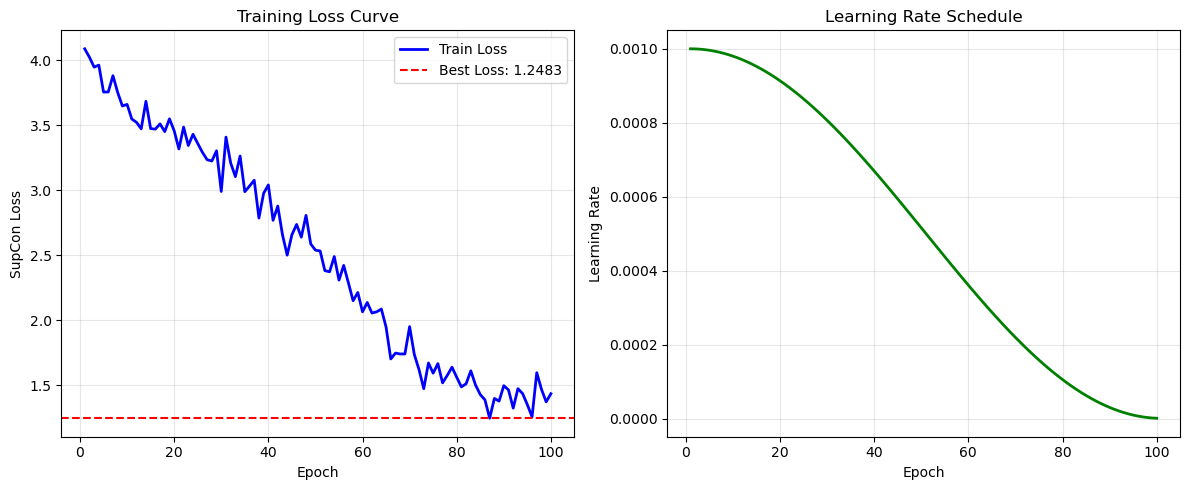

Training curves saved to ./supcon_output/training_curves.png


In [22]:
# Plot training curve
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', linewidth=2, label='Train Loss')
plt.axhline(y=best_loss, color='r', linestyle='--', label=f'Best Loss: {best_loss:.4f}')
plt.xlabel('Epoch')
plt.ylabel('SupCon Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True, alpha=0.3)

# Learning rate curve
plt.subplot(1, 2, 2)
log_df = training_logger.get_history()
if not log_df.empty and 'learning_rate' in log_df.columns:
    plt.plot(log_df['epoch'], log_df['learning_rate'], 'g-', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Training curves saved to {OUTPUT_DIR}/training_curves.png")

---
## 10. Save Final Encoder

In [ ]:
# Save the encoder weights (for downstream tasks)
encoder_path = f'{OUTPUT_DIR}/oct_encoder_supcon.pth'

# Load best model
best_checkpoint = checkpoint_manager.load_best_checkpoint()
if best_checkpoint:
    model.load_state_dict(best_checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {best_checkpoint['epoch'] + 1}")

# Save encoder only
torch.save(model.encoder.state_dict(), encoder_path)
print(f'\nOCT Encoder saved to: {encoder_path}')

# Save training configuration
config = {
    'batch_size': BATCH_SIZE,
    'num_epochs': NUM_EPOCHS,
    'learning_rate': LEARNING_RATE,
    'weight_decay': WEIGHT_DECAY,
    'temperature': TEMPERATURE,
    'embedding_dim': EMBEDDING_DIM,
    'image_size': IMAGE_SIZE,
    'selected_biomarkers': SELECTED_BIOMARKERS,
    'num_labels': len(label_to_idx),
    'train_samples': len(train_df),
    'val_samples': len(val_df),
    'best_loss': best_loss,
    'training_completed': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'seed': SEED
}

with open(f'{OUTPUT_DIR}/training_config.json', 'w') as f:
    json.dump(config, f, indent=2)

print(f'Training configuration saved to: {OUTPUT_DIR}/training_config.json')
print('\nConfiguration:')
print(json.dumps(config, indent=2))

---
## 11. Utility Functions for Loading Pretrained Encoder

In [ ]:
def load_pretrained_encoder(checkpoint_path, embedding_dim=256, device='cpu'):
    """
    Load the pretrained OCT encoder for downstream tasks.
    
    Args:
        checkpoint_path: Path to the saved encoder weights
        embedding_dim: Dimension of the embedding (must match training)
        device: Device to load the model on
    
    Returns:
        encoder: Loaded and ready-to-use encoder
    """
    encoder = OCTEncoder(embedding_dim=embedding_dim, pretrained=False)
    encoder.load_state_dict(torch.load(checkpoint_path, map_location=device))
    encoder.to(device)
    encoder.eval()
    return encoder


def extract_visit_embedding(encoder, oct_folder_path, transform, device='cpu'):
    """
    Extract embedding for a single visit (aggregating all B-scans).
    
    Args:
        encoder: Pretrained encoder
        oct_folder_path: Path to the OCT folder containing B-scans
        transform: Image preprocessing transform
        device: Device to use
    
    Returns:
        visit_embedding: [embedding_dim] averaged embedding
    """
    embeddings = []
    
    for scan_num in range(49):  # 0 to 48
        img_path = os.path.join(oct_folder_path, f'{scan_num}.tif')
        
        if not os.path.exists(img_path):
            continue
            
        try:
            image = Image.open(img_path).convert('RGB')
            image = transform(image).unsqueeze(0).to(device)
            
            with torch.no_grad():
                emb = encoder(image).squeeze(0).cpu().numpy()
            embeddings.append(emb)
        except Exception as e:
            print(f'Warning: Failed to process {img_path}: {e}')
            continue
    
    if len(embeddings) == 0:
        return np.zeros(encoder.embedding_dim)
    
    embeddings = np.stack(embeddings)
    return embeddings.mean(axis=0)


print('Utility functions defined!')
print()
print('Usage example:')
print('```python')
print("encoder = load_pretrained_encoder('supcon_output/oct_encoder_supcon.pth', device='cuda')")
print("embedding = extract_visit_embedding(encoder, 'Prime_FULL/02-010/W0/OD', val_transform)")
print('print(embedding.shape)  # (256,)')
print('```')

---
## Summary

### Key Files Generated:
1. `supcon_output/checkpoints/` - Periodic checkpoints for resuming
2. `supcon_output/checkpoints/best_model.pth` - Best model checkpoint
3. `supcon_output/oct_encoder_supcon.pth` - Final encoder weights
4. `supcon_output/training_config.json` - Training configuration
5. `supcon_output/training_log.csv` - Training metrics log
6. `supcon_output/training_curves.png` - Training visualization

### To Resume Training:
1. Set `RESUME_TRAINING = True`
2. Run all cells - training will automatically resume from the latest checkpoint

### Next Steps:
1. Use `load_pretrained_encoder()` to load the trained encoder
2. Apply to all visits for OCT embedding extraction
3. Proceed to multi-modal feature fusion for BCVA prediction